# HW1, Information Retrieval 1, 2017-2018

* Masoumeh Bakhtiariziabari (11813105)
* Marianne de Heer Kloots (11138351)
* Tharangni Sivaji (11611065)

# Theoretical Part

## 1. Hypothesis Testing – The problem of multiple comparisons
How many hypothesis tests, m, does it take to get to (with Type I error for each test = α):
* P(m<sup>th</sup> experiment gives significant result | m experiments lacking power to reject H<sub>0</sub>)?
* P(at least one significant result | m experiments lacking power to reject H<sub>0</sub>)?

<div style="background-color: lightyellow">
<ul><li> $$
        P(m^{\text{th}}\text{ experiment gives significant result} \mid m \text{ experiments lacking power to reject } H_0) \\
        \approx P(m^{\text{th}}\text{ experiment gives significant result} \mid H_0 \text{ is true in all m experiments}) \\
        \text{(i.e. only the } m^{\text{th}} \text{ result is significant whereas } (m-1) \text{ results are not significant)} \\
        = \boldsymbol{((1 - \alpha)^{m-1})\cdot\alpha}
        $$<br><br>
    <li> $$
        P(\text{at least one significant result} \mid m \text{ experiments lacking power to reject } H_0)\\
        = 1 - P(\text{no significant result})\\
        = \boldsymbol{1 - (1 - \alpha)^m}
        $$
</ul>
</div>

## 2. Bias and unfairness in Interleaving experiments
Balance interleaving has been shown to be biased in a number of corner cases. An example was given during the lecture with two ranked lists of length 3 being interleaved, and a randomly clicking population of users that resulted in algorithm A winning ⅔ of the time, even though in theory the percentage of wins should be 50% for both algorithms. Can you come up with a situation of two ranked lists of length 3 and a distribution of clicks over them for which Team-draft interleaving is unfair to the better algorithm?

<div style="background-color: lightyellow">
<ul>
<li> All interleaving comparison methods will fail to be sensitive if user clicks are not correlated with relevance.
<li> However, Team Draft Interleaving can suffer from insensitivity even when such correlations exist.
<li> Consider two lists $A$ and $B$ such that $A \in \{a, b, c\}$ and $B \in \{b, c, d\}$. 
<li> Assume $c$ is considered as the most relevant document. Then, since rank of $c^B > c^A \Rightarrow$ B should win.
<li> The interleaved comparisions for both the lists is given below:
<table><tr><th>a)</th><th></th><th></th><th>b)</th><th></th><th></th></tr><tr><td></td><td>a</td><td>A</td><td></td><td>b</td><td>B</td></tr><tr><td></td><td>b</td><td>B</td><td></td><td>a</td><td>A</td></tr><tr><td></td><td>c</td><td>A</td><td></td><td>c</td><td>B</td></tr><tr><th>c)</th><td></td><td></td><th>d)</th><td></td><td></td></tr><tr><td></td><td>b</td><td>B</td><td></td><td>a</td><td>A</td></tr><tr><td></td><td>a</td><td>A</td><td></td><td>b</td><td>B</td></tr><tr><td></td><td>c</td><td>A</td><td></td><td>c</td><td>B</td></tr></table>
<li> However, all possible 4 interleaved lists place $c$ at the same rank, i.e. third.
<li> This results in a tie.
<li> Hence Team Draft Interleaving fails to detect the preference for $B$.
</div>

# Experimental Part

In [1]:
from collections import Counter
import numpy as np
from itertools import product
from pprint import pprint
import random
from scipy import stats
from itertools import combinations
import math
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import Decimal
random.seed(11138351)

### Step 1: <font color='darkred'>Simulate Rankings of Relevance for *E* and *P*</font>

We generated 59049 different ranking pairs. 

This makes sense: each ranking pair consists of 10 relevance values (5 produced by each algorithm), all of which can take on any of the 3 grades (N, R, HR). So there should be 3<sup>10</sup> = 59049 different combinations, which matches our finding.

We then exclude all ranking pairs which have exactly the same relevance grade sequences, which leaves us with 58806 different combinations.


In [2]:
# define collections of algorithms and relevance grades
algorithms = ['P', 'E']
relevance_grades = ['N', 'HR', 'R']

# all possible ranking sequences
# list of rankings [('HR', 'HR', 'HR', 'HR', 'HR') ... ('N', 'N', 'N', 'N', 'N')]
rankings = [ranking for ranking in product(relevance_grades, repeat=5)]

# all algorithms paired with all rankings 
# (list of lists with elements e.g. ('P', ('HR', 'HR', 'HR', 'HR', 'HR')))
algorithm_rankings = [list(product(alg, rankings)) for alg in algorithms]

# all possible pairs of P and E with their rankings
all_ranking_pairs = [pair for pair in product(*algorithm_rankings)]

# all ranking pairs except equals
ranking_pairs = [pair for pair in product(*algorithm_rankings) if pair[0][1] != pair[1][1]]

# pretty print
print('number of combinations:', len(all_ranking_pairs))
print('number of non-equal combinations:', len(ranking_pairs),'\n')
print("3 randomly selected sample of 10 ranking pairs as an example:")
pprint(random.sample(ranking_pairs, 3))

number of combinations: 59049
number of non-equal combinations: 58806 

3 randomly selected sample of 10 ranking pairs as an example:
[(('P', ('HR', 'HR', 'HR', 'R', 'R')), ('E', ('R', 'R', 'R', 'N', 'R'))),
 (('P', ('R', 'HR', 'R', 'R', 'HR')), ('E', ('R', 'HR', 'N', 'R', 'N'))),
 (('P', ('R', 'R', 'N', 'N', 'N')), ('E', ('HR', 'N', 'HR', 'N', 'R')))]


### Step 2: <font color='darkred'>Implement Evaluation Measures</font>

Below, we implemented Precision@k for k=3, Average precision, nDCG@5 and ERR. As initial input we passed the un-refined ranking pair.So, you can notice that for every method mean of all of it's values for P and E will be equal.

We assumed that as ground truth we have 30 distinct documents contatainig 10 highly relevant, 10 relevant and 10 non-relevant documents.

In [3]:
#p@K function

def precision(k,_ranking_pairs):
    
    def calc_precision(i,x):
        rel_counter = 0.0
        prec = 0.0
        for j in range(k):
            if _ranking_pairs[i][x][1][j] == 'HR' or _ranking_pairs[i][x][1][j] == 'R':
                rel_counter += 1
                prec += rel_counter/(1.0+j)
        return prec
    
    prec_list = []
    for i in range(len(_ranking_pairs)):
        p_prec = calc_precision(i,0)
        e_prec = calc_precision(i,1)
        prec_list.append((p_prec/k,e_prec/k))
        #print(p_prec,e_prec)
    
    return prec_list


In [4]:
prec = precision(3,ranking_pairs)

print('mean of all precision values for P & E (should be equal):\n', 
      np.mean(prec, axis=0),'\n')
print('mean of a random sample of 100 pairs:\n', 
      np.mean(random.sample(prec, 100), axis=0),'\n')

random_query_index_list = random.sample(range(len(ranking_pairs)), 5)
print("Precision at K=3 for 5 random queries:")
print("query number \t P \t E")
for i in random_query_index_list:
    print("query ",i,": \t",'%.3f'%prec[i][0],"\t",'%.3f'%prec[i][1])

mean of all precision values for P & E (should be equal):
 [ 0.58024691  0.58024691] 

mean of a random sample of 100 pairs:
 [ 0.57666667  0.59388889] 

Precision at K=3 for 5 random queries:
query number 	 P 	 E
query  49278 : 	 1.000 	 1.000
query  9658 : 	 0.389 	 0.667
query  4003 : 	 0.111 	 1.000
query  19254 : 	 0.389 	 0.667
query  50173 : 	 1.000 	 0.389


In [5]:
def average_prec(k_max,_ranking_pairs):
    temp_list = []
    ap_list = [[0,0] for i in range(len(_ranking_pairs))]
    for k in range(1,k_max+1):
        temp_list = precision(k,_ranking_pairs)
        for index,item in enumerate(temp_list):
            ap_list[index] = (np.array(ap_list[index])+np.array(item)).tolist()
    for item in ap_list:
        item[:] = [i / k_max for i in item]
    return ap_list       
    

In [6]:
k_max = 5
avg_prec = average_prec(k_max,ranking_pairs)

print('mean of all AP values for P & E (should be equal):\n', 
      np.mean(avg_prec, axis=0),'\n')
print('mean of a random sample of 100 pairs:\n', 
      np.mean(random.sample(avg_prec, 100), axis=0),'\n')

random_query_index_list = random.sample(range(len(ranking_pairs)), 5)
print("Average Precision for 5 random queries:")
print("query number \t P \t\t\t\t AP \t E \t\t\t\t AP")
for i in random_query_index_list:
    print("query ",i,": \t",ranking_pairs[i][0][1], "\t",'%.3f'%avg_prec[i][0],'\t',ranking_pairs[i][1][1],'\t','%.3f'%avg_prec[i][1])

mean of all AP values for P & E (should be equal):
 [ 0.59282716  0.59282716] 

mean of a random sample of 100 pairs:
 [ 0.55654778  0.61611778] 

Average Precision for 5 random queries:
query number 	 P 				 AP 	 E 				 AP
query  54251 : 	 ('R', 'R', 'N', 'R', 'R') 	 0.813 	 ('N', 'HR', 'HR', 'R', 'HR') 	 0.332
query  27361 : 	 ('HR', 'HR', 'N', 'HR', 'R') 	 0.813 	 ('N', 'N', 'HR', 'R', 'N') 	 0.097
query  31080 : 	 ('HR', 'HR', 'R', 'N', 'R') 	 0.902 	 ('HR', 'N', 'R', 'HR', 'R') 	 0.661
query  8688 : 	 ('N', 'HR', 'N', 'R', 'R') 	 0.197 	 ('R', 'R', 'N', 'HR', 'N') 	 0.781
query  53558 : 	 ('R', 'R', 'N', 'HR', 'R') 	 0.813 	 ('N', 'R', 'R', 'HR', 'HR') 	 0.332


In [7]:
#-------------calc ideal dcg based on ground truth [10 HR, 10 R, 10 N]--------------------------
def calc_ideal_dgc(k):
    idcg_rel = [0.9]*10 + [0.6]*10 + [0.1]*10
    idcg = 0
    for index in range(min(k, len(idcg_rel))):
        idcg += ((2**idcg_rel[index]) - 1)/(math.log2(2+index))
    return idcg
        

In [8]:
# We used the second formula of DCG from slide 6 of http://www.cs.cornell.edu/courses/cs4300/2013fa/lectures/evaluation-1-4pp.pdf
# Normalize DCG at rank n by the DCG value at rank n of the ideal ranking(stanford slide)

def ndcg(max_k,query_index,method):    
    all_dcg_k = []
    
    #--------------------make dcg list for all k-----------------------------
    for r in range(0,max_k):
        if ranking_pairs[query_index][method][1][r] == 'HR':
            rel_num = 0.9
        elif ranking_pairs[query_index][method][1][r] == 'R':
            rel_num = 0.6
        else:
            rel_num = 0.1
            
        if len(all_dcg_k) > 0:   
            all_dcg_k.append((((2**rel_num) - 1)/(math.log2(2+r))) + all_dcg_k[-1])
        else:
            all_dcg_k.append(((2**rel_num) - 1)/(math.log2(2+r)))
            
            
    #----------------calculate ideal dcg------------------------------------      
    idcg = calc_ideal_dgc(max_k)
        
    #--------------------------convert dcg to ndcg--------------------------   
    if(idcg == 0):
        all_dcg_k[:] = [0 for x in all_dcg_k]
    else:
        all_dcg_k[:] = [x / idcg for x in all_dcg_k]
     
    return all_dcg_k

#-----------------------call ndcg function for all 59000 queries------------------
ndcg_list = []
max_k = 5
for i in range(len(ranking_pairs)):
    p_dcg = ndcg(max_k,i,0)
    e_dcg = ndcg(max_k,i,1)
    ndcg_list.append((p_dcg[-1],e_dcg[-1]))

    
    

In [9]:
print('mean of all NDCD values for P & E (should be equal):\n', 
      np.mean(ndcg_list, axis=0),'\n')
print('mean of a random sample of 100 pairs:\n', 
      np.mean(random.sample(ndcg_list, 100), axis=0),'\n')
random_query_index_list = random.sample(range(len(ranking_pairs)), 5)
print("NDCG@5 for 5 random queries:")
print("query number \t P \t\t\t\t NDCG \t E \t\t\t\t NDCG")
for index in random_query_index_list:
    print("query %d"%index,":",'\t',ranking_pairs[index][0][1], "\t", '%.3f'%ndcg_list[index][0],'\t',ranking_pairs[index][1][1], "\t",'%.3f'%ndcg_list[index][1],'\n')

mean of all NDCD values for P & E (should be equal):
 [ 0.55944776  0.55944776] 

mean of a random sample of 100 pairs:
 [ 0.58302092  0.59476895] 

NDCG@5 for 5 random queries:
query number 	 P 				 NDCG 	 E 				 NDCG
query 16607 : 	 ('N', 'R', 'HR', 'HR', 'R') 	 0.549 	 ('HR', 'R', 'HR', 'R', 'R') 	 0.801 

query 39411 : 	 ('R', 'N', 'N', 'N', 'N') 	 0.257 	 ('R', 'HR', 'R', 'N', 'HR') 	 0.660 

query 1069 : 	 ('N', 'N', 'N', 'HR', 'HR') 	 0.337 	 ('HR', 'N', 'R', 'HR', 'N') 	 0.615 

query 1814 : 	 ('N', 'N', 'N', 'R', 'HR') 	 0.278 	 ('HR', 'HR', 'HR', 'HR', 'HR') 	 1.000 

query 22895 : 	 ('HR', 'N', 'HR', 'HR', 'HR') 	 0.804 	 ('HR', 'R', 'HR', 'HR', 'HR') 	 0.913 



In [10]:
# ERR

def numerical(relevance_sequence):
    """
    Convert a relevance grade sequence to a sequence of numerical 
    values, based on the relevance grades given.
    E.g. ['HR', 'HR', 'HR', 'R', 'N'] returns [2, 2, 2, 1, 0]
    """
    numerical_relevance_sequence = [0.6 if grade == 'R' \
                                    else 0.9 if grade == 'HR' else 0.1 \
                                    for grade in relevance_sequence]
    return numerical_relevance_sequence

def R_function(g, g_max):
    return (2**g - 1)/(2**g_max)

def ERR(relevance_sequence):
    """
    Compute the ERR based on Algorithm 2 in 
    https://pdfs.semanticscholar.org/7e3c/f6492128f915112ca01dcb77c766129e65cb.pdf
    """
    p = 1
    ERR = 0
    n = len(relevance_sequence)
    g_max = max(relevance_sequence)
    
    for r in range(1, n + 1):
        g = relevance_sequence[r - 1]
        R = R_function(g, g_max)
        ERR = ERR + p * (R/r)
        p = p * (1 - R)
    return ERR

ERR_list = []
for P, E in ranking_pairs:
    ERR_P = ERR(numerical(P[1]))
    ERR_E = ERR(numerical(E[1]))
    ERR_list.append((ERR_P, ERR_E))
    
print('mean of all ERR values for P & E (should be equal):\n', 
      np.mean(ERR_list, axis=0))
print('mean of a random sample of 100 pairs:\n', 
      np.mean(random.sample(ERR_list, 100), axis=0),'\n')

random_query_index_list = random.sample(range(len(ranking_pairs)), 5)
print("ERR for 5 random queries:")
print("query number \t P \t\t\t\t ERR \t E \t\t\t\t ERR")
for index in random_query_index_list:
    print("query %d"%index,":",'\t',ranking_pairs[index][0][1], "\t", '%.3f'%ERR_list[index][0],'\t',ranking_pairs[index][1][1], "\t",'%.3f'%ERR_list[index][1],'\n')


mean of all ERR values for P & E (should be equal):
 [ 0.45258501  0.45258501]
mean of a random sample of 100 pairs:
 [ 0.46900341  0.43896196] 

ERR for 5 random queries:
query number 	 P 				 ERR 	 E 				 ERR
query 32404 : 	 ('HR', 'HR', 'R', 'R', 'HR') 	 0.643 	 ('R', 'R', 'N', 'HR', 'N') 	 0.444 

query 54250 : 	 ('R', 'R', 'N', 'R', 'R') 	 0.513 	 ('N', 'HR', 'HR', 'R', 'N') 	 0.362 

query 13056 : 	 ('N', 'HR', 'R', 'R', 'R') 	 0.350 	 ('R', 'R', 'HR', 'R', 'N') 	 0.478 

query 53466 : 	 ('R', 'R', 'N', 'HR', 'HR') 	 0.467 	 ('R', 'R', 'HR', 'N', 'R') 	 0.475 

query 3924 : 	 ('N', 'N', 'HR', 'R', 'HR') 	 0.267 	 ('N', 'HR', 'R', 'R', 'R') 	 0.350 



### Step 3: <font color='darkred'>Calculate the 𝛥measure</font>
Calculated  𝛥measure = measure<sub>E</sub>-measure<sub>P</sub> for AP, nDCG@5 and ERR methods for all *P* and *E* ranking pairs and saved only those pairs for which *E* outperforms *P*.

We used output of this delta measure later to compare offline methods via randomization test, simulation rcm and sdbm and comparing online click and offline experiments.


In [11]:
def measure_diff(measure_list, _ranking_pairs, query_index_list):
    pos_result = []
    diff_list = []
    for i in query_index_list:
        diff = measure_list[i][1] - measure_list[i][0]
        if diff > 0:
            pos_result.append(_ranking_pairs[i])
            diff_list.append(diff)
    return pos_result, diff_list

In [12]:
random_query_index_list = [i for i in range(len(ranking_pairs))]
#for ap:
print("Based on 𝛥measure for AP: ")
ap_pos_result,diff_avgprec = measure_diff(avg_prec, ranking_pairs, random_query_index_list)
print("There are ",len(ap_pos_result)," experiments that E out perform P")
print("-------------------------------------------------------------------------------------------------------")
#for nDCG:
print("Based on 𝛥measure for nDCG: ")
ndcg_pos_result,diff_nDCG = measure_diff(ndcg_list, ranking_pairs, random_query_index_list)
print("There are ",len(ndcg_pos_result)," experiments that E out perform P")
print("-------------------------------------------------------------------------------------------------------")
#for ERR:
print("Based on 𝛥measure for ERR: ")
err_pos_result,diff_ERR = measure_diff(ERR_list, ranking_pairs, random_query_index_list)
print("There are ",len(err_pos_result)," experiments that E out perform P")


Based on 𝛥measure for AP: 
There are  27962  experiments that E out perform P
-------------------------------------------------------------------------------------------------------
Based on 𝛥measure for nDCG: 
There are  29403  experiments that E out perform P
-------------------------------------------------------------------------------------------------------
Based on 𝛥measure for ERR: 
There are  29403  experiments that E out perform P


### Step 4: <font color='darkred'>Implement Interleaving </font>
Implement Team-Draft Interleaving and generate a ranked list containig of 5 documents for every query


In [13]:
#Team-Draft Interleaving
#P and E as two interleaving lists

def team_draft_interleaving(_ranking_pairs):
    """
    Input: [[(documents for P for query 1,documents for E for query 1)]
            ,[(documents for P for query 2,documents for E for query 2)]
            ,[(documents for P for query 3,documents for E for query 3)],...]
            
    output: [[combined documents of P and E for query 1]
            ,[combined documents of P and E for query 2]
            ,[combined documents of P and E for query 3],...]
            
    Here we assume all of documents in A and B are unique and independent otherwise we should change the
    code to eliminate the document from both A and B when we insert it to I.
    """
    
    all_I = []
    for i in range(len(_ranking_pairs)):
        A = _ranking_pairs[i][0][1]
        B = _ranking_pairs[i][1][1]
        team_A = []
        team_B = []
        I = []
        #--------- Do interleaving on all documents from A and B-----------
        while len(team_A) < len(A) or len(team_B) < len(B):
            RandBit = random.getrandbits(1)
            #pick from A
            if len(team_A) < len(team_B) or (len(team_A) == len(team_B) and RandBit == 1):
                I.append((A[len(team_A)],0))
                team_A.append(I[-1])        
            else:
                #pick from B
                I.append((B[len(team_B)],1))
                team_B.append(I[-1])
        #------------- pick the first five interleaved document to show to the user----------------
        all_I.append(I[:5])
    return all_I


In [14]:
def find_winner(_click,_all_I):
    """
    input: generated clicks by rcm or sdbm methods-clicks should be 0 or 1,
    and the interleaved ranking lists-containig sets indicating of amount of relevancy and it's source(P or E)
    
    output: winner of every query
    """
    winner_list = []
    for query_index in range(len(_all_I)):
        h_a = 0
        h_b = 0
        for index, item in enumerate(_all_I[query_index]):
            if _click[query_index][index] > 0:
                if item[1] == 0:
                    h_a += 1
                if item[1] == 1:
                    h_b += 1
        if(h_a > h_b):
            winner_list.append('P')
        elif(h_a == h_b):
            winner_list.append('NoPref')
        else:
            winner_list.append('E')
    return winner_list
    

### Step 5: <font color='darkred'>Implement User Clicks Simulation</font>

For calculating rcm parameter (rho) we use rho = #clicks/#unique documents.

For calculating sdbm parameter (sigma), we consider every query from the training file one unique session. So, we calculate a global sigma instead of a local one and we use sigma = #satisfication/#click_num.

In [15]:
def learn_rcm_param(_train_file):
    c = 0
    query_num = 0.0
    click_num = 0.0
    doc = Counter()
    for line in _train_file:
        info = line.split()
        if info[2] == 'Q':
            for i in info[5:]:
                doc[i] += 1
        if info[2] == 'C':
            click_num += 1
        

    doc_num = len(doc)#to eliminate redundant documents
    
    #--------------param = #clicks/#unique documents---------------
    _rcm_param = click_num/doc_num
    return _rcm_param
 

In [16]:
train_file = open("YandexRelPredChallenge.txt","r")
rho = learn_rcm_param(train_file)
print("rho parameter for the rcm is equal to ",rho)

rho parameter for the rcm is equal to  0.2830797784644546


In [17]:
#SDBM:
def learn_sdbm_param(_train_file):        

    prev_action = ''
    satisfy_num = 0
    click_num = 0
    
    for line in _train_file:
        
        info = line.split() 
        #----total number of clicks--------
        if info[2] == 'C':
            click_num += 1
        #-------check if user after sending the query clicked or not, and take acount his last click as satisfaction
        if info[2] == 'Q' and prev_action == 'C':
            satisfy_num += 1
        prev_action = info[2]
    if prev_action == 'C':
        satisfy_num += 1
    sigma = satisfy_num/click_num
    
    return sigma


In [18]:
train_file = open("YandexRelPredChallenge.txt","r")
sigma = learn_sdbm_param(train_file)
print("sigma parameter for the sdbm is equal to ",sigma)

sigma parameter for the sdbm is equal to  0.5121189928157913


### Step 6: <font color='darkred'>Simulate Interleaving Experiment</font>

In [19]:
def simulate_rcm_click(_I,_ru):
    simulated_click = []
    for i in range(len(_I)):
        if(random.random() < _ru):
            simulated_click.append(1)
        else:
            simulated_click.append(0)
    return simulated_click

In [20]:
def simulate_sdbm_click(_I,_sigma):
    simulated_click = [0]*len(_I)
    attraction = {'HR':0.9,'R':0.6,'N':0.1}
    for index,item in enumerate(_I):
        if random.random() < attraction[item[0]]:
            simulated_click[index]= 1
            if random.random() < _sigma:
                return simulated_click
    return simulated_click

In [21]:
def proportion(winner):
    """
    input:   a counter including {'E':E_count,'P':P_count,'NoPref':NoPref_count}
    output:  ratio of choosing E over P
    """
    ratio = winner['E']/(winner['P'] + winner['E'])
    return ratio

In [22]:

def run_simulation(data_set,train_file,method,iteration_num):
    #-------------learn param-------------------------
    if method == 'rcm':
        param = learn_rcm_param(train_file)#estimate rho
    else:
        param = learn_sdbm_param(train_file)#estimate sigma    
    
    avg_ratio_E = 0
    ratio_list = []
    winner_matrix = []
    for i in range(iteration_num):
        #----------------generate clicks-------------------
        interleaved_set = team_draft_interleaving(data_set)
        if method == 'rcm':
            click_list = [simulate_rcm_click(interleaved_set[i],param) for i in range(len(interleaved_set))]
        else:
            click_list = [simulate_sdbm_click(interleaved_set[i],param) for i in range(len(interleaved_set))]
        #-----------find winner for every query with the generated clicks---------------------
        winner_list = find_winner(click_list, interleaved_set)
        winner_counter = Counter(winner_list)
        prop = proportion(winner_counter)
        avg_ratio_E += prop
        
        #------------save the proportion of times E is winner toward P for the given interleaving-----------------------
        ratio_list.append(prop)
        winner_matrix.append(winner_list)

    avg_ratio_E /= iteration_num
    #-----------save the proportion of times E is winner toward P for each query---------------
    query_winner = list(map(list, zip(*winner_matrix)))
    qwinner_ratio = []    
    for item in query_winner:
        qwinner_counter = Counter(item)
        qwinner_ratio.append(proportion(qwinner_counter))
        
    return avg_ratio_E,ratio_list, qwinner_ratio

In [23]:
# change iteration_num (= number of samples generated) if you want to run less iterations to save time
# running the simulation for 100 iterations takes a bit more than 1 minute wall clock time for us
# so around 7 minutes for all conditions in this cell 
train_file = open("YandexRelPredChallenge.txt","r")
iteration_num = 100

train_file.seek(0)
%time ap_rcm_avg_ratio_E ,ap_rcm_ratio_list, ap_rcm_qwinner_ratio = run_simulation(ap_pos_result,train_file,'rcm',iteration_num)
print("Applying rcm on AP:",'\n',ap_rcm_avg_ratio_E)

train_file.seek(0)
ap_sdbm_avg_ratio_E, ap_sdbm_ratio_list, ap_sdbm_qwinner_ratio= run_simulation(ap_pos_result,train_file,'sdbm',iteration_num)
print("Applying sdbm on AP:",'\n',ap_sdbm_avg_ratio_E)

train_file.seek(0)
ndcg_rcm_avg_ratio_E, ndcg_rcm_ratio_list, ndcg_rcm_qwinner_ratio= run_simulation(ndcg_pos_result,train_file,'rcm',iteration_num)
print("Applying rcm on NDCG:",'\n',ndcg_rcm_avg_ratio_E)

train_file.seek(0)
ndcg_sdbm_avg_ratio_E, ndcg_sdbm_ratio_list, ndcg_sdbm_qwinner_ratio = run_simulation(ndcg_pos_result,train_file,'sdbm',iteration_num)
print("Applying sdbm on NDCG:",'\n',ndcg_sdbm_avg_ratio_E)

train_file.seek(0)
err_rcm_avg_ratio_E, err_rcm_ratio_list,err_rcm_qwinner_ratio= run_simulation(err_pos_result,train_file,'rcm',iteration_num)
print("Applying rcm on ERR:",'\n',err_rcm_avg_ratio_E)

train_file.seek(0)
err_sdbm_avg_ratio_E, err_sdbm_ratio_list,err_sdbm_qwinner_ratio= run_simulation(err_pos_result,train_file,'sdbm',iteration_num)
print("Applying sdbm on ERR:",'\n',err_sdbm_avg_ratio_E)

CPU times: user 1min 16s, sys: 1.93 s, total: 1min 18s
Wall time: 1min 38s
Applying rcm on AP: 
 0.5005345759446176
Applying sdbm on AP: 
 0.7035606107070016
Applying rcm on NDCG: 
 0.5003115636472529
Applying sdbm on NDCG: 
 0.6934559464593779
Applying rcm on ERR: 
 0.5001194397810851
Applying sdbm on ERR: 
 0.7204283469472617


### Step 7: <font color='darkred'>Results and Analysis </font>



### Analysis based on click model used

AP Ttest_indResult(statistic=-451.78083640667143, pvalue=2.5452313653683369e-300)


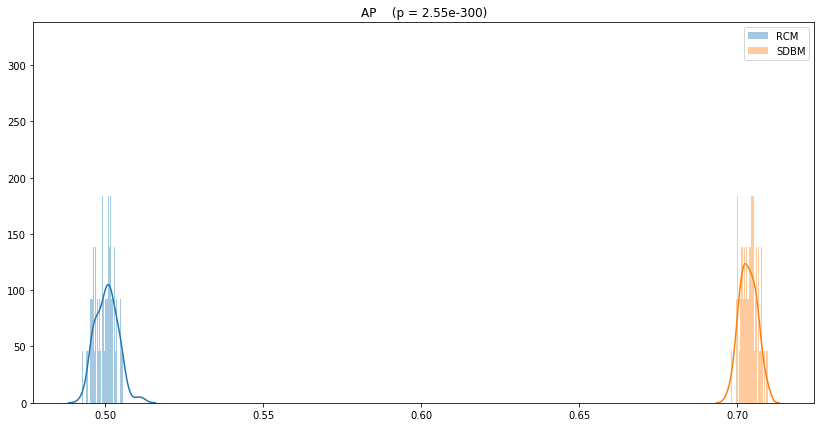

ERR Ttest_indResult(statistic=-456.97137638468678, pvalue=2.6567313808287893e-301)


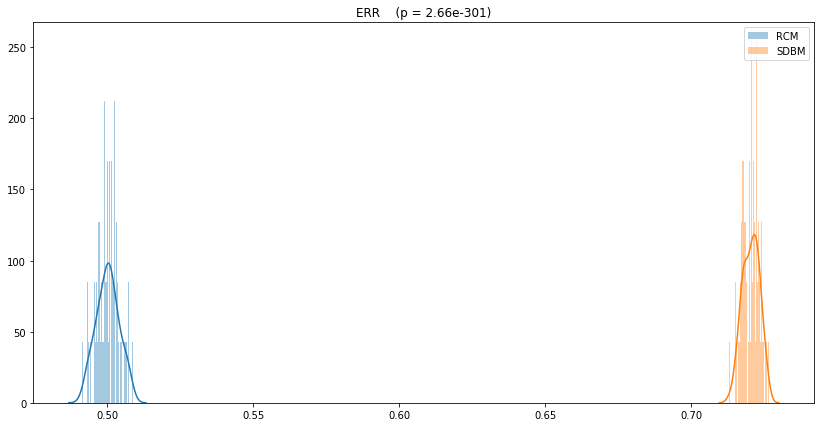

nDCG Ttest_indResult(statistic=-384.5879203829756, pvalue=1.7240350285356524e-286)


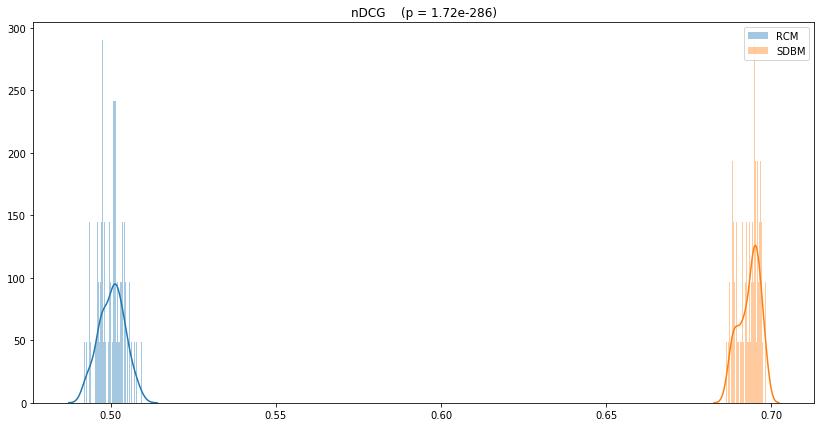

In [24]:
# t-tests between click models
proportion_lists = {
    'RCM': {
        'AP': ap_rcm_ratio_list,
        'ERR': err_rcm_ratio_list,
        'nDCG': ndcg_rcm_ratio_list,
    },
    'SDBM': {
        'AP': ap_sdbm_ratio_list,
        'ERR': err_sdbm_ratio_list,
        'nDCG': ndcg_sdbm_ratio_list,
    }
}

ttest_results = {}

for index, eval_measure in enumerate(['AP', 'ERR', 'nDCG']):
    ttest_results[eval_measure] = stats.ttest_ind(proportion_lists['RCM'][eval_measure], proportion_lists['SDBM'][eval_measure])
    print(eval_measure, ttest_results[eval_measure])
    
    min_x = min(proportion_lists['RCM'][eval_measure] + proportion_lists['SDBM'][eval_measure])
    max_x = max(proportion_lists['RCM'][eval_measure] + proportion_lists['SDBM'][eval_measure])
    bins = np.linspace(min_x, max_x, 1000)

    plt.clf()
    plt.figure(figsize=(14,7))
    sns.distplot(proportion_lists['RCM'][eval_measure], bins, label='RCM')
    sns.distplot(proportion_lists['SDBM'][eval_measure], bins, label='SDBM')
    plt.title(eval_measure + '    (p = ' + '%.2e' % Decimal(ttest_results[eval_measure][1]) + ')')
    plt.legend(loc='upper right')
    plt.savefig('proportiondists_' + eval_measure + '.png')
    plt.show()
    plt.close()

<div style="background-color: lightyellow">
<p>Comparing between the models, we see consistently for each evaluation measure that the proportion distribution of SDBM is higher on average than the proportion distribution of RCM. This means that with the SDBM, E had higher win proportions than with the RCM. This result makes sense: in the RCM, clicks are modelled randomly, so the relevance of documents is not taken into account. However, the SDBM click model does take the relevance into account, and since we selected the queries where E outperformed P, we would expect to see higher win proportions for E than for P using the SDBM. We performed two-sided t-tests to compare this hypothesis, setting $\alpha = 0.05$ to determine whether the distributions differ significantly.</p>

<p>The proportion distributions are shown in the graphs above. The t-test results comparing both distributions for every measure are printed above. Since $p <<< 0.05$ for every measure, we conclude that our results compare the hypothesis: using the SDBM consistently we consistently get higher win proportions for E than using the RCM.</p>
</div>

### Analysis based on evaluation method used

#### Offline methods

In [25]:
diff_list = []

err_p = []
err_e = []

ap_p = []
ap_e = []

ndcg_p = []
ndcg_e = []

for i in range(len(ranking_pairs)):
    err_p.append(ERR_list[i][0])
    err_e.append(ERR_list[i][1])
    ap_p.append(avg_prec[i][0])
    ap_e.append(avg_prec[i][1])
    ndcg_p.append(ndcg_list[i][0])
    ndcg_e.append(ndcg_list[i][1])

offline_methods = [['Avg Precision',ap_e, ap_p], ['nDCG',ndcg_e, ndcg_p], ['ERR',err_e, err_p]]

In [26]:
def randomization(t, c):
    ##Load topic scores for 2 systems
    temp = [0]*(len(t))
    random_index = random.sample(range(len(ranking_pairs)), 29403)

    ##Randomly swap values per topic
    for i in random_index:
        temp[i] = t[i]
        t[i] = c[i]
        c[i] = temp[i]

    ##Compute average for each system
    avg_t = np.mean(t, axis=0)
    avg_c = np.mean(c, axis=0)

    ##Compute difference between averages
    avg_difference = avg_t - avg_c

    return avg_difference

In [27]:
for item in offline_methods:
    #Loop for many times
    for i in range(100):
        ##Add difference to array
        diff_list.append(randomization(item[1], item[2]))

    #Sort Array
    sort_list = sorted(diff_list)

    #Significance test
    t_obs = np.mean(err_e, axis=0) - np.mean(err_p, axis=0)
    t_obs = [t_obs]*(len(sort_list))

    p_value = stats.ttest_ind(t_obs,sort_list)
    
    print('\n',item[0])
    print("p-value: ", p_value.pvalue)

    if(p_value.pvalue < 0.05):
        print("Reject null hypothesis. \nThis means that E > P")
    else:
        print("Accept null hypothesis. \nThis means that E = P")


 Avg Precision
p-value:  0.679569513142
Accept null hypothesis. 
This means that E = P

 nDCG
p-value:  0.757389493859
Accept null hypothesis. 
This means that E = P

 ERR
p-value:  5.61368138201e-35
Reject null hypothesis. 
This means that E > P


<div style="background-color: lightyellow">
To compare the offline measures, we used the randomization test. For each measure, we compared the scores for E and P. We determine whether the difference between the randomized lists is significant using a t-test with $\alpha = 0.05$. We found significant differences ($p <<< 0.05$) for each measure, so we conclude that the scores for E are on average larger than the scores for P (for each measure).
</div>

#### Online methods

RCM
F_onewayResult(statistic=0.30521964687003833, pvalue=0.73719236556551104)


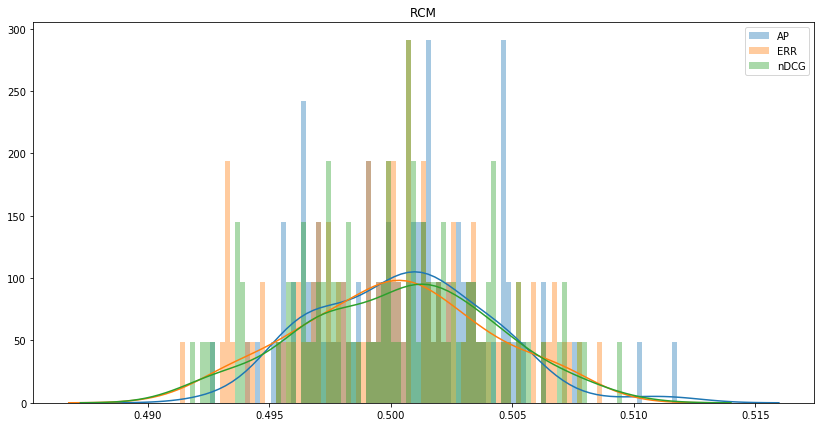

SDBM
F_onewayResult(statistic=2123.4873031369734, pvalue=1.1887819845086653e-176)


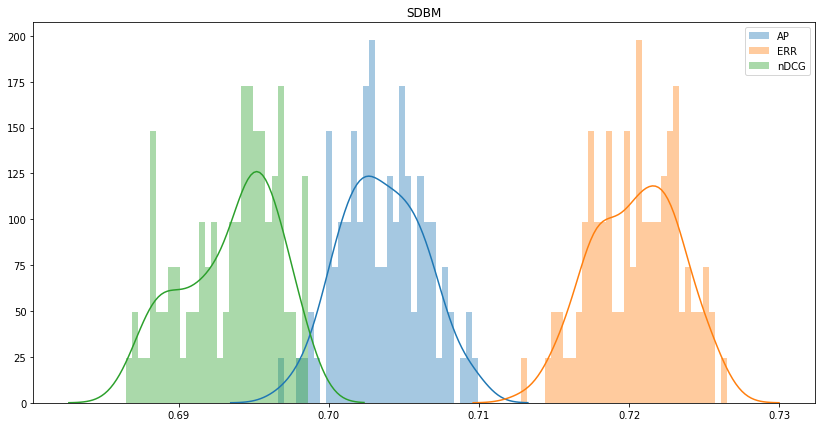

In [28]:
# ANOVA between evaluation measures (for each click model)
#plt.figure(figsize=(14,7))
for index,model in enumerate(['RCM', 'SDBM']):
    print(model)
    print(stats.f_oneway(proportion_lists[model]['AP'], 
                         proportion_lists[model]['ERR'], 
                         proportion_lists[model]['nDCG']))
    
    min_x = min(proportion_lists[model]['AP'] + proportion_lists[model]['ERR'] + proportion_lists[model]['nDCG'])
    max_x = max(proportion_lists[model]['AP'] + proportion_lists[model]['ERR'] + proportion_lists[model]['nDCG'])
    bins = np.linspace(min_x, max_x, 100)
    
    plt.clf()
    plt.figure(figsize=(14,7))
    sns.distplot(proportion_lists[model]['AP'], bins, label='AP')
    sns.distplot(proportion_lists[model]['ERR'], bins, label='ERR')
    sns.distplot(proportion_lists[model]['nDCG'], bins, label='nDCG')
    plt.title(model)
    plt.legend(loc='upper right')
    plt.savefig('proportiondists_' + model + '.png')
    plt.show()
    plt.close()

<div style="background-color: lightyellow">
We also compared between measures for each model. Here we see again that the RCM produces win proportions around ~0.5 for all measures, while for the SDBM the results differ per measure. In the graphs plotted above, we see that the distributions overlap completely in the RCM. The graph for the SDBM shows that using the ERR measure results in the highest win proportions for E, followed by AP and then nDCG. Therefore our hypothesis is that the win proportion distributions for the RCM do not differ significantly, but the win proportion distributions for the SDBM do.<br><br>

We tested this using a one-way ANOVA, where we set $\alpha = 0.05$ to determine whether the differences between distributions are significant. As expected, the difference between the win proportion distributions for the RCM was not significant ($p = 0.542$), but the differences between the win proportion distributions for de SDBM are ($p <<< 0.05$). Therefore we conclude that the win proportions for E are consistently higher if we use ERR than if we use AP, and higher if we use AP then if we use nDCG. The distribution graphs are shown above.
</div>

### Correlation between offline and online methods

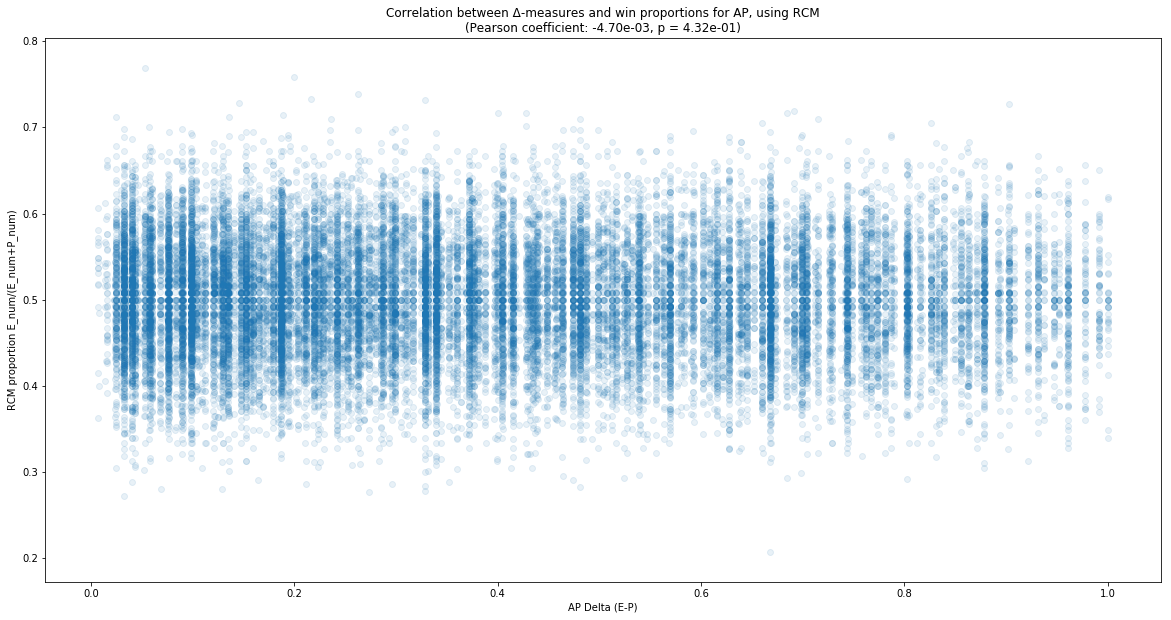

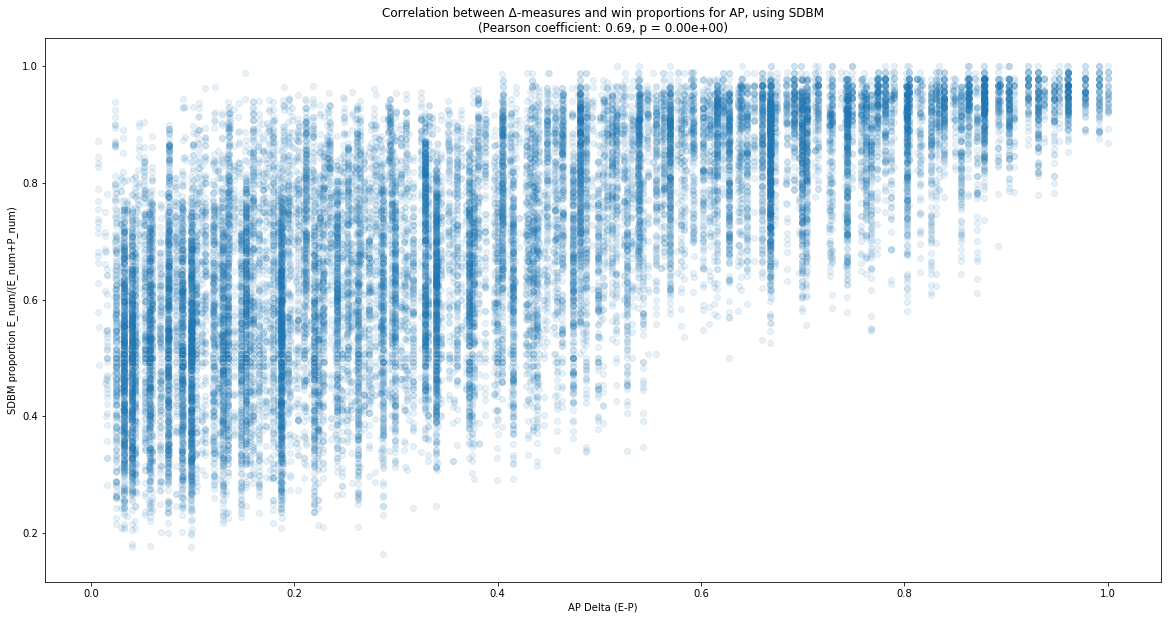

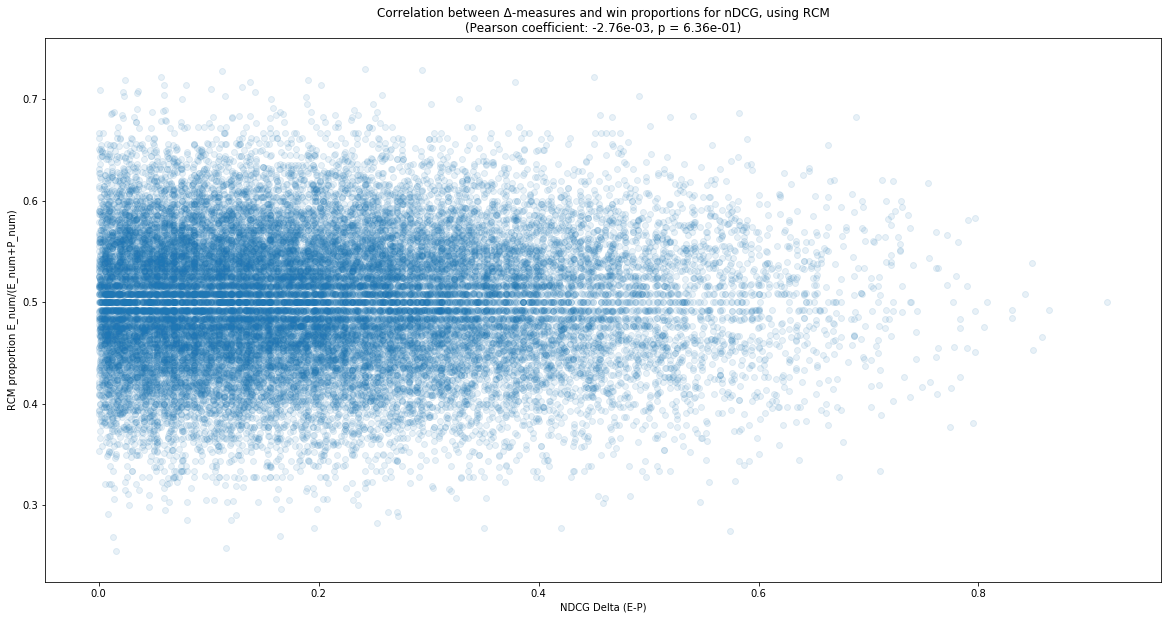

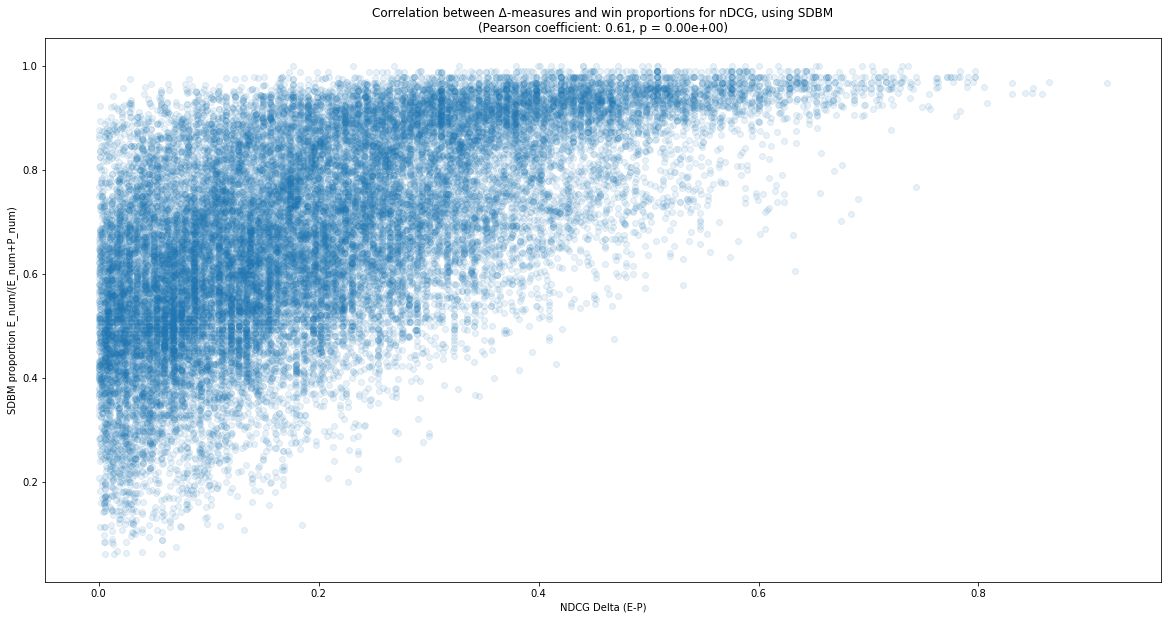

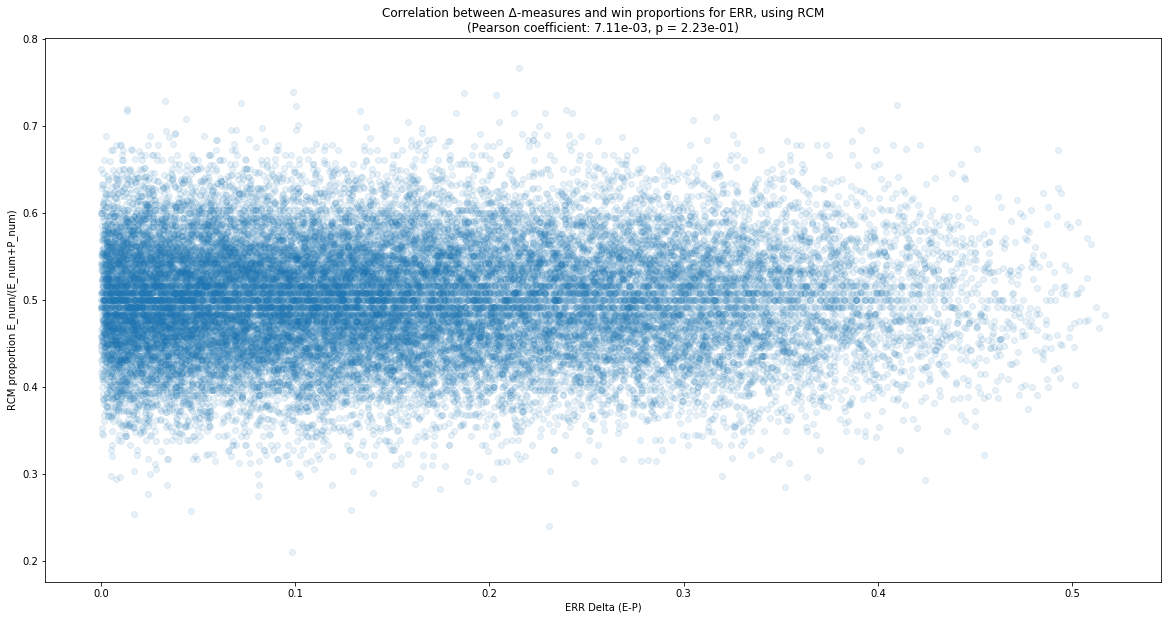

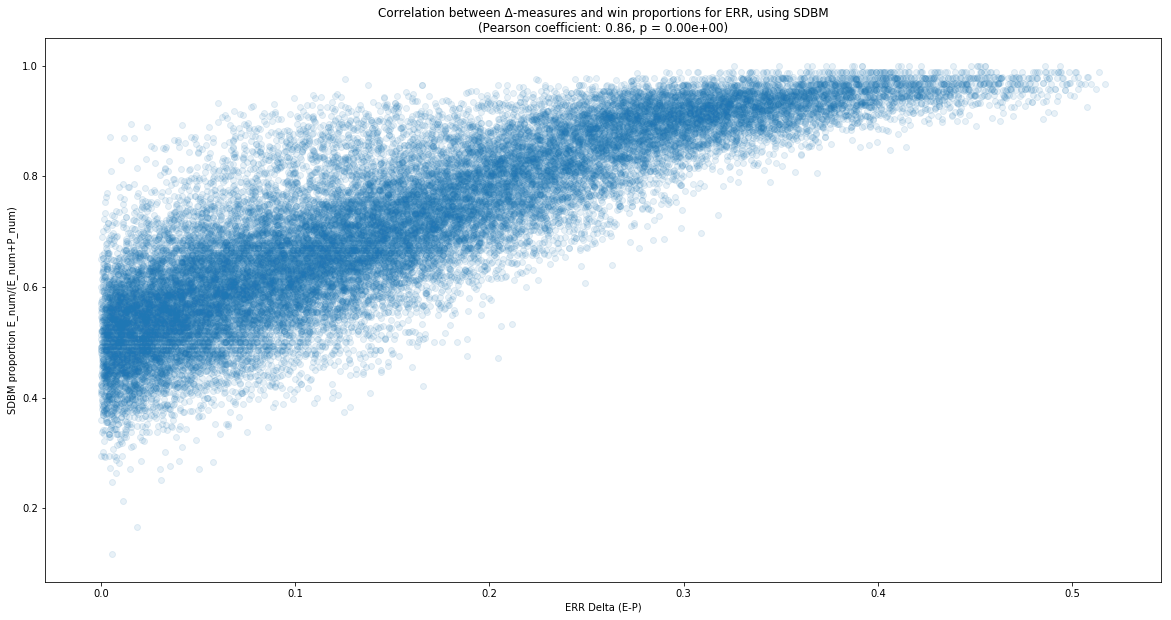

pearson correlation coefficient between Δ-measures and win proportions for ERR and SDBM:
	 0.855495415801 
	 p = 0.0
pearson correlation coefficient between Δ-measures and win proportions for ERR and RCM:
	 0.00710516460266 
	 p = 0.223107071544
pearson correlation coefficient between Δ-measures and win proportions for nDCG and SDBM:
	 0.610556855306 
	 p = 0.0
pearson correlation coefficient between Δ-measures and win proportions for nDCG and RCM:
	 -0.0027611806057 
	 p = 0.635893036401
pearson correlation coefficient between Δ-measures and win proportions for AP and SDBM:
	 0.68836495002 
	 p = 0.0
pearson correlation coefficient between Δ-measures and win proportions for AP and RCM:
	 -0.00469964136492 
	 p = 0.431963683547


In [29]:
def plot_online_offline(offline_delta, online_avg, x_name, y_name, filename, title):
    plt.figure(figsize=(20,10))
    plt.scatter(offline_delta, online_avg, alpha=.1)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(title)
    plt.savefig(filename + '.png')
    plt.show()
    plt.close()
    
pearson_correlation_coefficients = { 
    'AP': {
        'RCM': stats.pearsonr(diff_avgprec, ap_rcm_qwinner_ratio),
        'SDBM': stats.pearsonr(diff_avgprec, ap_sdbm_qwinner_ratio) 
    },
    'nDCG': {
        'RCM': stats.pearsonr(diff_nDCG, ndcg_rcm_qwinner_ratio),
        'SDBM': stats.pearsonr(diff_nDCG, ndcg_sdbm_qwinner_ratio)
    },
    'ERR': {
        'RCM': stats.pearsonr(diff_ERR, err_rcm_qwinner_ratio),
        'SDBM': stats.pearsonr(diff_ERR, err_sdbm_qwinner_ratio)
    }
}

plot_online_offline(diff_avgprec, 
                    ap_rcm_qwinner_ratio, 
                    "AP Delta (E-P)", 
                    "RCM proportion E_num/(E_num+P_num)", 
                    "AP_RCM",
                    "Correlation between Δ-measures and win proportions for AP, using RCM\n" + 
                    "(Pearson coefficient: " + '%.2e'%Decimal(pearson_correlation_coefficients['AP']['RCM'][0]) + 
                    ", p = " '%.2e'%Decimal(pearson_correlation_coefficients['AP']['RCM'][1]) + ')')
plot_online_offline(diff_avgprec,
                    ap_sdbm_qwinner_ratio,
                    "AP Delta (E-P)",
                    "SDBM proportion E_num/(E_num+P_num)",
                    "AP_SDBM",
                    "Correlation between Δ-measures and win proportions for AP, using SDBM\n" + 
                    "(Pearson coefficient: " + '%.2f'%Decimal(pearson_correlation_coefficients['AP']['SDBM'][0]) + 
                    ", p = " '%.2e'%Decimal(pearson_correlation_coefficients['AP']['SDBM'][1]) + ')')
plot_online_offline(diff_nDCG, 
                    ndcg_rcm_qwinner_ratio, 
                    "NDCG Delta (E-P)", 
                    "RCM proportion E_num/(E_num+P_num)",
                    "nDCG_RCM",
                    "Correlation between Δ-measures and win proportions for nDCG, using RCM\n" + 
                    "(Pearson coefficient: " + '%.2e'%Decimal(pearson_correlation_coefficients['nDCG']['RCM'][0]) + 
                    ", p = " '%.2e'%Decimal(pearson_correlation_coefficients['nDCG']['RCM'][1]) + ')')
plot_online_offline(diff_nDCG, 
                    ndcg_sdbm_qwinner_ratio, 
                    "NDCG Delta (E-P)", 
                    "SDBM proportion E_num/(E_num+P_num)",
                    "nDCG_SDBM",
                    "Correlation between Δ-measures and win proportions for nDCG, using SDBM\n" + 
                    "(Pearson coefficient: " + '%.2f'%Decimal(pearson_correlation_coefficients['nDCG']['SDBM'][0]) + 
                    ", p = " '%.2e'%Decimal(pearson_correlation_coefficients['nDCG']['SDBM'][1]) + ')')
plot_online_offline(diff_ERR,
                    err_rcm_qwinner_ratio,
                    "ERR Delta (E-P)",
                    "RCM proportion E_num/(E_num+P_num)",
                    "ERR_RCM",
                    "Correlation between Δ-measures and win proportions for ERR, using RCM\n" + 
                    "(Pearson coefficient: " + '%.2e'%Decimal(pearson_correlation_coefficients['ERR']['RCM'][0]) + 
                    ", p = " '%.2e'%Decimal(pearson_correlation_coefficients['ERR']['RCM'][1]) + ')')
plot_online_offline(diff_ERR,
                    err_sdbm_qwinner_ratio,
                    "ERR Delta (E-P)",
                    "SDBM proportion E_num/(E_num+P_num)",
                    "ERR_SDBM",
                    "Correlation between Δ-measures and win proportions for ERR, using SDBM\n" + 
                    "(Pearson coefficient: " + '%.2f'%Decimal(pearson_correlation_coefficients['ERR']['SDBM'][0]) + 
                    ", p = " '%.2e'%Decimal(pearson_correlation_coefficients['ERR']['SDBM'][1]) + ')')

for measure in pearson_correlation_coefficients.keys():
    for model in pearson_correlation_coefficients[measure].keys():
        print('pearson correlation coefficient between Δ-measures and win proportions for', 
              measure, 'and', model + ':')
        print('\t', pearson_correlation_coefficients[measure][model][0], '\n\t', 
              'p =', pearson_correlation_coefficients[measure][model][1])

<div style="background-color: lightyellow">
To compare the offline measures with the online measures, we wanted to see how the (offline) Δ-measures correlate with the win proportions of E. For example, if the difference in the offline measure score (AP, nDCG or ERR) between P and E is large, we expect that the win proportion of E would also be larger. Because the RCM does not take relevance into account, our hypothesis is that there is no correlation between the offline measures and the win proportions using the RCM. However, we do expect that there will be a significant positive correlation between the offline measures and the win proportions of the SDBM: we would expect that the win proportions increase when the Δ-measures increase.<br><br>

To test this hypothesis, we computed the Pearson correlation coefficients and the corresponding p-values. For each measure, we computed the Pearson correlation between the Δ-measures and the win proportions using both click models. The Pearson correlation coefficient varies between -1 and +1, with 0 indicating lack of correlation. The p-value indicates the probability that an uncorrelated system would produce datasets that have a Pearson correlation at least as extreme as the one computed. We set $\alpha = 0.05$ to determine whether the calculated Pearson correlation is significant. The Pearson correlation coefficients and their corresponding p-values are printed above.<br><br>

As expected, we find no correlation between the offline and online measures using the RCM at all: we find very small Pearson correlation coefficients, but the p-values are not significant ($p > 0.05$). This makes sense, since the offline correlation compute the score based on the relevance of retrieved documents (where we have selected the ones where E outperforms P), while the RCM models random clicking and does not take any relevance scores into account. Therefore there is no relation between the offline and online measures in this case and indeed we do not expect a correlation.<br>
For the SDBM, we do find significant positive correlations between all offline and online measures. The correlation coefficient between the offline and online measures is ~0.7 for Average Precision ($p <<< 0.05$ or even $p = 0.0$), ~0.6 for nDCG ($p <<< 0.05$ or even $p = 0.0$), and ~0.9 for ERR ($p <<< 0.05$ or even $p = 0.0$). This confirms our hypothesis, so we conclude that there is a significant positive correlation between the offline measures and the online measures using the SDBM: the higher the Δ-measures, the higher the win proportions will be. The graphs above also show this: whereas the datapoints are distributed randomly in the graphs that plot the RCM results, we see clear upwards trends in the graphs that plot the SDBM results.
</div>